<a href="https://colab.research.google.com/github/dgallacher1/simpleclass/blob/master/AlphaStopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alpha range calculations

This note will detail calculations of range of alpha particles in gold and silver using ASTAR stopping power database data.

In [238]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
mp.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 10]
import numpy as np
import math
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy.stats import gaussian_kde
import scipy as sp
import seaborn as sns
#Read in table of Radon emanation data from drive
#Google nonsense
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

##Alphas in Gold

In [239]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/StoppingPower/"

####################
#Change fname to run on other files
fname = "GoldASTAR"
####################

filename = "{}{}.csv".format(path,fname)
golddata = pd.read_csv(filename, sep=',')
column_names = ['Kinetic Energy(MeV)','Electronic Stopping Power (MeV /cm)','Nuclear Stopping Power (MeV /cm)','Total Stopping Power (MeV /cm)','CSDA Range (cm)','Projected Range (cm)','Detour']
golddata.columns = column_names
golddata = golddata[2:]
for name in column_names:
  golddata[name] = golddata[name].apply(pd.to_numeric, errors='coerce')

den_gold = 19.3 #g/cm3
for name in column_names[1:4]:
  golddata[name] = golddata[name]*den_gold

for name in column_names[4:5]:
  golddata[name] = golddata[name]/den_gold

#Check to make sure it's read properly
display(golddata) 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Kinetic Energy(MeV),Electronic Stopping Power (MeV /cm),Nuclear Stopping Power (MeV /cm),Total Stopping Power (MeV /cm),CSDA Range (cm),Projected Range (cm),Detour
2,0.0010,221.950,111.554000,333.890,0.000005,0.000006,0.0662
3,0.0015,281.780,122.169000,403.370,0.000006,0.000009,0.0705
4,0.0020,331.960,128.731000,461.270,0.000007,0.000011,0.0747
5,0.0025,378.280,132.977000,511.450,0.000008,0.000013,0.0786
6,0.0030,420.740,135.872000,555.840,0.000009,0.000015,0.0823
...,...,...,...,...,...,...,...
118,800.0000,177.946,0.051917,178.139,2.709845,52.000000,0.9950
119,850.0000,171.770,0.049022,171.770,2.994819,57.500000,0.9950
120,900.0000,166.173,0.046513,166.173,3.290155,63.200000,0.9950
121,950.0000,160.962,0.044197,161.155,3.595855,69.100000,0.9950


(0.001, 100000.0)

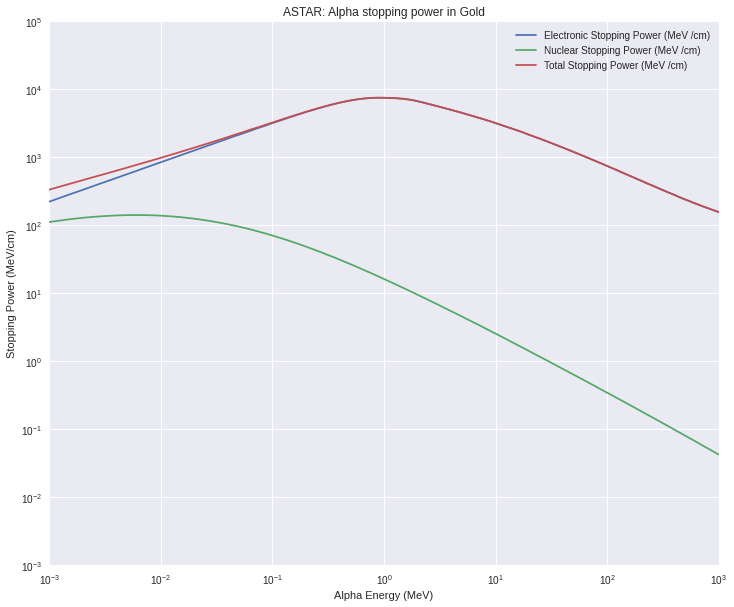

In [240]:
#Alphas in Gold here
golddata.plot(x='Kinetic Energy(MeV)',y=[column_names[1],column_names[2],column_names[3]])
plt.yscale('log')
plt.title('ASTAR: Alpha stopping power in Gold')
plt.xscale('log')
plt.ylabel('Stopping Power (MeV/cm)')
plt.xlabel('Alpha Energy (MeV)')
plt.xlim(1e-3,1e3)
plt.ylim(1e-3,1e5)

Text(0.5, 1.0, 'Range of Alphas in Gold')

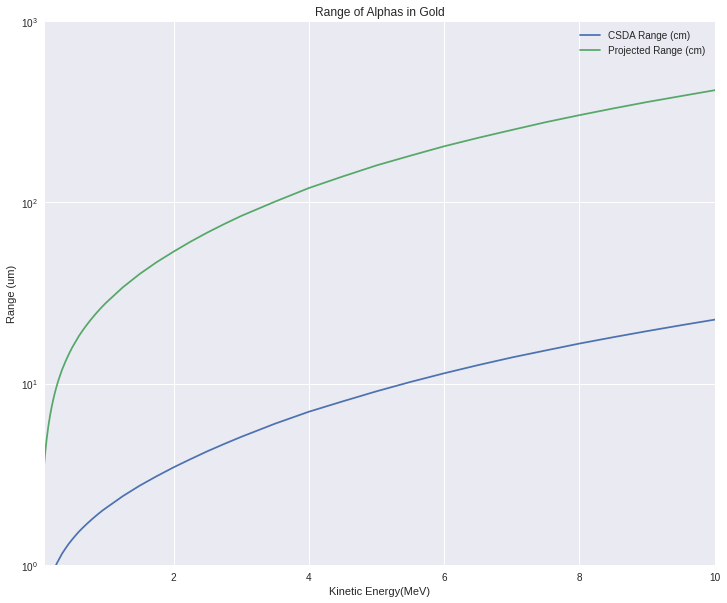

In [241]:
#Range
golddata[column_names[4]] = golddata[column_names[4]]/100*1e6
golddata[column_names[5]] = golddata[column_names[5]]/100*1e6

golddata.plot(x=column_names[0],y=[column_names[4],column_names[5]])
plt.xlim(1e-1,10)
plt.yscale('log')
plt.ylim(1,1000)
plt.ylabel('Range (um)')
plt.title('Range of Alphas in Gold')

In [242]:
#Function to calculating outgoing alpha energy as a function of thickness for coating, integrates down in 1 keV steps using stopping power interpolation function
def outgoingEnergy(E_init,dE,thickness,stopping):
  outgoing_energy = np.empty_like(thickness)
  for index,t in enumerate(thickness):
    E_o = E_init
    x = 0.0
    tt = t*1e-4 #Convert um to cm
    #Loop over thicknesses integrating down in 1keV steps
    while x < tt:
      if E_o < 1.1e-3:#Dont extrapolate the stopping power curve
        break
      dx = 1.0/stopping(E_o)*dE
      x+=dx
      E_o -=dE
    #Done loop over thicknesses
    outgoing_energy[index]=E_o
  return outgoing_energy

In [243]:
from scipy import interpolate
#Interpolation function for stopping power distribution using total stopping power
stopping = interpolate.interp1d(golddata[column_names[0]],golddata[column_names[3]])

#What values of thickness 
thickness = np.linspace(1e-3,12,num=100,endpoint=True) #um
dE = 1e-3 #1keV Steps
initial_energy = 5.480 #MeV
outgoing_energy = outgoingEnergy(initial_energy,dE,thickness,stopping)
thicknessGold = interpolate.interp1d(outgoing_energy,thickness)#Interpolation function for outgoing energy and thickness

5.48


Text(0.5, 1.0, 'Am241 Alphas: Outgoing alpha energy through Gold using total stopping power from ASTAR')

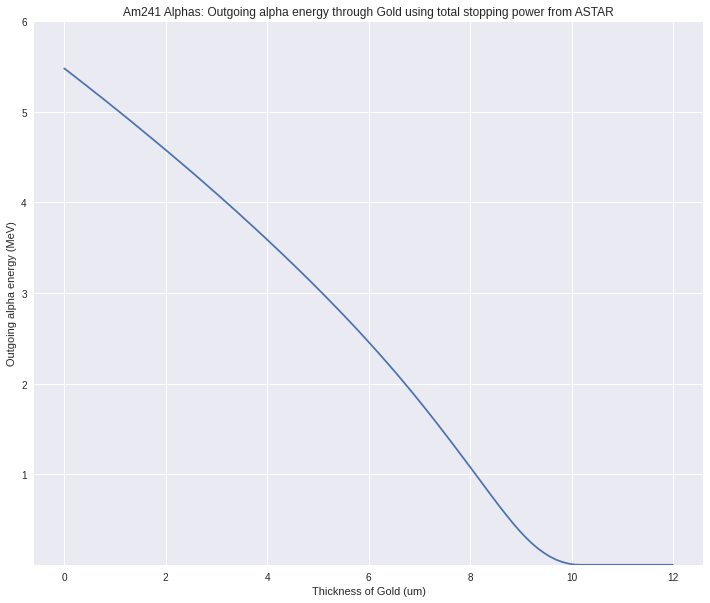

In [244]:
plt.plot(thickness,outgoing_energy)
plt.ylim(1e-3,6)
plt.ylabel('Outgoing alpha energy (MeV)')
plt.xlabel('Thickness of Gold (um)')
plt.title('Am241 Alphas: Outgoing alpha energy through Gold using total stopping power from ASTAR')

In [245]:
#Print out range of gold thicknesses based on source energies
source_energies = [4.571,4.655,4.563,4.462,4.547,4.625,4.551]#MeV from Pushpa's measurements
avg = 0.0
for source in source_energies:
  tS = thicknessGold(source)
  avg+=tS
  print('Estimated thickness for source with energy ({} MeV) = {:3.4} um'.format(source,tS))
print('Average gold thickness = {:1.4} um'.format(avg/float(len(source_energies))))

Estimated thickness for source with energy (4.571 MeV) = 2.018 um
Estimated thickness for source with energy (4.655 MeV) = 1.838 um
Estimated thickness for source with energy (4.563 MeV) = 2.035 um
Estimated thickness for source with energy (4.462 MeV) = 2.249 um
Estimated thickness for source with energy (4.547 MeV) = 2.07 um
Estimated thickness for source with energy (4.625 MeV) = 1.902 um
Estimated thickness for source with energy (4.551 MeV) = 2.061 um
Average gold thickness = 2.025 um


##Alphas in Silver


In [246]:
####################
#Change fname to run on other files
fname = "SilverASTAR"
####################

filename = "{}{}.csv".format(path,fname)
silverdata = pd.read_csv(filename, sep=',')
silverdata.columns = column_names
silverdata = silverdata[2:]
for name in column_names:
  silverdata[name] = silverdata[name].apply(pd.to_numeric, errors='coerce')

den_silver = 10.49 #g/cm3
#Scale columns with silver density
for name in column_names[1:4]:
  silverdata[name] = silverdata[name]*den_silver
for name in column_names[4:5]:
  silverdata[name] = silverdata[name]/den_silver

#Check to make sure it's read properly
display(silverdata) 

,Kinetic Energy(MeV),Electronic Stopping Power (MeV /cm),Nuclear Stopping Power (MeV /cm),Total Stopping Power (MeV /cm),CSDA Range (cm),Projected Range (cm),Detour
2,0.0010,328.3370,145.811000,473.0990,0.000003,0.000004,0.1226
3,0.0015,399.6690,154.203000,554.9210,0.000004,0.000006,0.1318
4,0.0020,460.5110,159.448000,619.9590,0.000005,0.000008,0.1401
5,0.0025,514.0100,161.546000,675.5560,0.000006,0.000009,0.1476
6,0.0030,562.2640,162.595000,724.8590,0.000007,0.000011,0.1547
...,...,...,...,...,...,...,...
118,800.0000,114.3410,0.034407,114.3410,4.175405,43.700000,0.9972
119,850.0000,110.1450,0.032519,110.1450,4.623451,48.300000,0.9972
120,900.0000,106.9980,0.030736,106.9980,5.081030,53.200000,0.9973
121,950.0000,103.1167,0.029267,103.2216,5.557674,58.100000,0.9973


(0.001, 100000.0)

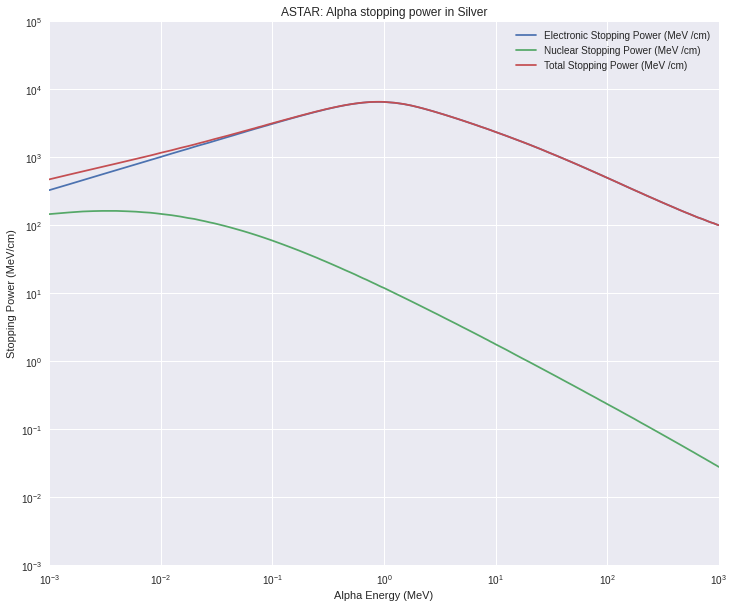

In [247]:
silverdata.plot(x='Kinetic Energy(MeV)',y=[column_names[1],column_names[2],column_names[3]])
plt.yscale('log')
plt.title('ASTAR: Alpha stopping power in Silver')
plt.xscale('log')
plt.ylabel('Stopping Power (MeV/cm)')
plt.xlabel('Alpha Energy (MeV)')
plt.xlim(1e-3,1e3)
plt.ylim(1e-3,1e5)

Text(0.5, 1.0, 'Range of Alphas in Silver')

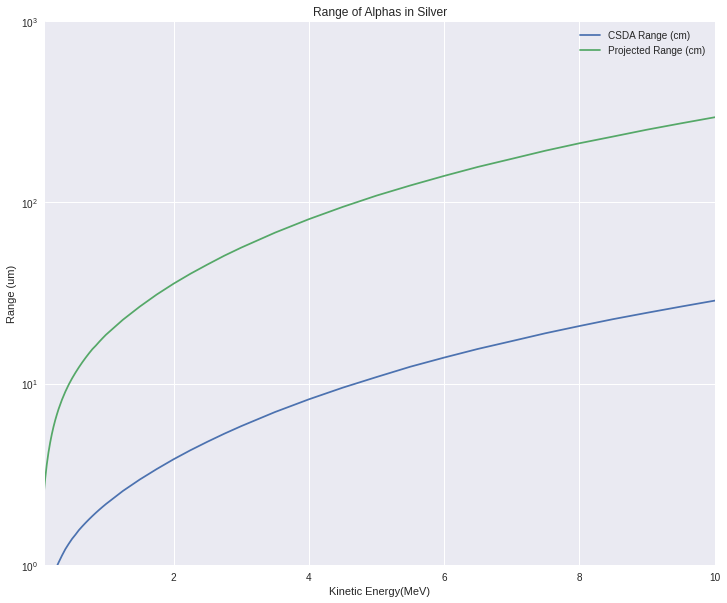

In [248]:
#Range
silverdata[column_names[4]] = silverdata[column_names[4]]/100*1e6
silverdata[column_names[5]] = silverdata[column_names[5]]/100*1e6

silverdata.plot(x=column_names[0],y=[column_names[4],column_names[5]])
plt.xlim(1e-1,10)
plt.yscale('log')
plt.ylim(1,1000)
plt.ylabel('Range (um)')
plt.title('Range of Alphas in Silver')

In [249]:
#Interpolation function for stopping power distribution using total stopping power
stopping = interpolate.interp1d(silverdata[column_names[0]],silverdata[column_names[3]])
#What values of thickness 
thickness = np.linspace(1e-3,12,num=100,endpoint=True) #um
dE = 1e-3 #1keV Steps
initial_energy = 4.571 #MeV
outgoing_energy_silver = outgoingEnergy(initial_energy,dE,thickness,stopping)
outgoingEnergySilver = interpolate.interp1d(thickness,outgoing_energy_silver)

4.571


Outgoing Alpha Energy for 1um of silver using initial energy of 4.571 MeV = 4.193605467122134 MeV


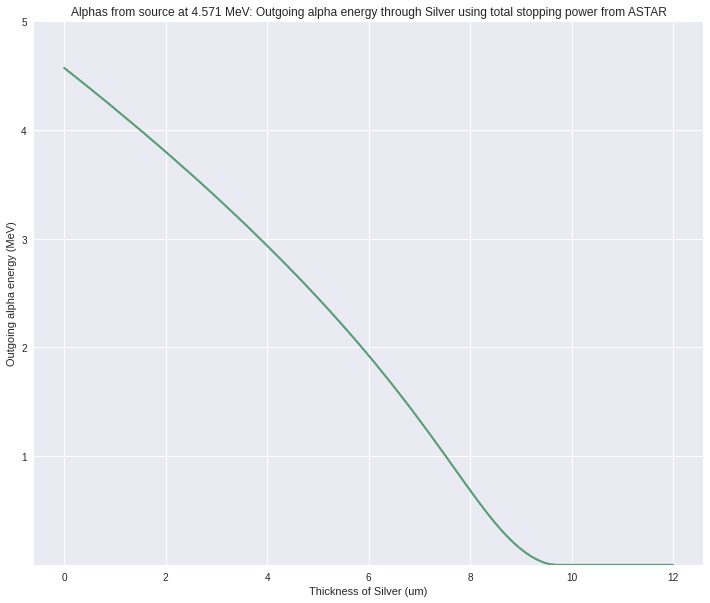

In [250]:
plt.plot(thickness,outgoingEnergySilver(thickness))
plt.plot(thickness,outgoing_energy_silver)
plt.ylim(1e-3,5)
plt.ylabel('Outgoing alpha energy (MeV)')
plt.xlabel('Thickness of Silver (um)')
plt.title('Alphas from source at {} MeV: Outgoing alpha energy through Silver using total stopping power from ASTAR'.format(initial_energy))
print('Outgoing Alpha Energy for 1um of silver using initial energy of {} MeV = {} MeV'.format(initial_energy,outgoingEnergySilver(1)))

In [251]:
#loop over source energies and print out expected output energies based on coatings
coatings = [1.0,4.0,6.0,8.0,10.0,10.6,0.0] #Expected coatings from Pushpa in um
energy_out = np.empty_like(coatings)
for index,source in enumerate(source_energies):
  t = np.linspace(1e-3,coatings[index],num=100,endpoint=True)
  oE = outgoingEnergy(source,dE,t,stopping)
  energy_out[index]=oE[-1]


4.571
4.655
4.563
4.462
4.547
4.625
4.551


In [252]:
#Print Energies
data = []
data.append(source_energies)
data.append(coatings)
data.append(energy_out)
data = np.transpose(data)

df = pd.DataFrame(data)
df.columns = ['Source Energy(MeV)','Planned Coating','Expected Outoing Alpha Energy(MeV)']
display(df)
fname = 'source_energies.csv'
df.to_csv('{}/{}'.format(path,fname), index=True,header=df.columns,mode='w')

,Source Energy(MeV),Planned Coating,Expected Outoing Alpha Energy(MeV)
0,4.571,1.0,4.194
1,4.655,4.0,3.040
2,4.563,6.0,1.914
3,4.462,8.0,0.503
4,4.547,10.0,0.001
5,4.625,10.6,0.001
6,4.551,0.0,4.551


Thickness required for 200.0 keV outgoing alphas = 8.868 um
5.48


(0.0, 6.0)

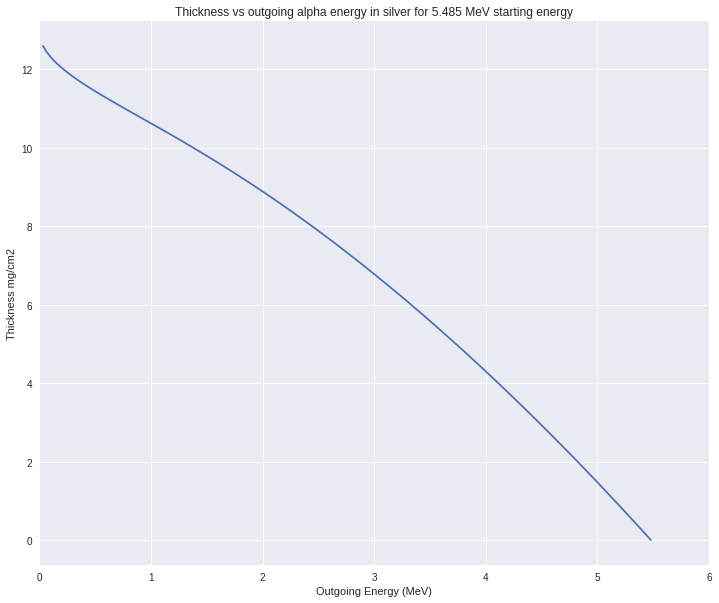

In [254]:
#Assuming an initial source energy of 4.57 MeV what is the required thickness for the source to have a target outgoing alpha energy
thicknessSilver = interpolate.interp1d(outgoing_energy_silver,thickness)#Interpolation function for outgoing energy and thickness
eTarget=0.2#Target Thickness
print('Thickness required for {} keV outgoing alphas = {:2.4} um'.format(eTarget*1000,thicknessSilver(eTarget)))

#Plot to compare to paper
outgoing_energy_silver_full = outgoingEnergy(5.48,dE,thickness,stopping)
thicknessSilver_full = interpolate.interp1d(outgoing_energy_silver_full,thickness)
plt.plot(outgoing_energy_silver_full,thicknessSilver_full(outgoing_energy_silver_full)*den_silver*1e-4*1e3)#Conver to units in paper
plt.ylabel('Thickness mg/cm2')
plt.title('Thickness vs outgoing alpha energy in silver for 5.48 MeV starting energy')
plt.xlabel('Outgoing Energy (MeV)')
plt.xlim(-0,6)
